<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Data-Prep" data-toc-modified-id="Data-Prep-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Prep</a></span><ul class="toc-item"><li><span><a href="#Workflow" data-toc-modified-id="Workflow-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Workflow</a></span></li><li><span><a href="#Build-Sqlite-Data-Base" data-toc-modified-id="Build-Sqlite-Data-Base-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Build Sqlite Data Base</a></span></li><li><span><a href="#Clean-Data" data-toc-modified-id="Clean-Data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Clean Data</a></span></li><li><span><a href="#Create-SVID-Columns" data-toc-modified-id="Create-SVID-Columns-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Create SVID Columns</a></span></li><li><span><a href="#Normalize-Signal-Data" data-toc-modified-id="Normalize-Signal-Data-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Normalize Signal Data</a></span></li><li><span><a href="#Generate-Files-with-Different-Sampling-Rates" data-toc-modified-id="Generate-Files-with-Different-Sampling-Rates-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Generate Files with Different Sampling Rates</a></span></li><li><span><a href="#Calculate-Cross-Correlation-Matrix-(CCM)" data-toc-modified-id="Calculate-Cross-Correlation-Matrix-(CCM)-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Calculate Cross Correlation Matrix (CCM)</a></span></li><li><span><a href="#Store-SigCCM-Data-in-HDF5" data-toc-modified-id="Store-SigCCM-Data-in-HDF5-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Store SigCCM Data in HDF5</a></span></li><li><span><a href="#Shape-Data-for-LSTM-Input" data-toc-modified-id="Shape-Data-for-LSTM-Input-2.9"><span class="toc-item-num">2.9&nbsp;&nbsp;</span>Shape Data for LSTM Input</a></span></li><li><span><a href="#Pandas-IO-Tools" data-toc-modified-id="Pandas-IO-Tools-2.10"><span class="toc-item-num">2.10&nbsp;&nbsp;</span>Pandas IO Tools</a></span><ul class="toc-item"><li><span><a href="#HDF5-Files" data-toc-modified-id="HDF5-Files-2.10.1"><span class="toc-item-num">2.10.1&nbsp;&nbsp;</span>HDF5 Files</a></span></li><li><span><a href="#PyArrow-and-Parque-Files" data-toc-modified-id="PyArrow-and-Parque-Files-2.10.2"><span class="toc-item-num">2.10.2&nbsp;&nbsp;</span>PyArrow and Parque Files</a></span></li><li><span><a href="#IO-Routines" data-toc-modified-id="IO-Routines-2.10.3"><span class="toc-item-num">2.10.3&nbsp;&nbsp;</span>IO Routines</a></span></li></ul></li><li><span><a href="#Save-Pickled-Files" data-toc-modified-id="Save-Pickled-Files-2.11"><span class="toc-item-num">2.11&nbsp;&nbsp;</span>Save Pickled Files</a></span><ul class="toc-item"><li><span><a href="#Save-to-Dill-File" data-toc-modified-id="Save-to-Dill-File-2.11.1"><span class="toc-item-num">2.11.1&nbsp;&nbsp;</span>Save to Dill File</a></span></li><li><span><a href="#Save-to-HDF5-File" data-toc-modified-id="Save-to-HDF5-File-2.11.2"><span class="toc-item-num">2.11.2&nbsp;&nbsp;</span>Save to HDF5 File</a></span></li><li><span><a href="#Save-to-PyArrow-Parquet-File" data-toc-modified-id="Save-to-PyArrow-Parquet-File-2.11.3"><span class="toc-item-num">2.11.3&nbsp;&nbsp;</span>Save to PyArrow-Parquet File</a></span></li></ul></li><li><span><a href="#Load-Files" data-toc-modified-id="Load-Files-2.12"><span class="toc-item-num">2.12&nbsp;&nbsp;</span>Load Files</a></span><ul class="toc-item"><li><span><a href="#Load-from-Pickled-Files" data-toc-modified-id="Load-from-Pickled-Files-2.12.1"><span class="toc-item-num">2.12.1&nbsp;&nbsp;</span>Load from Pickled Files</a></span></li><li><span><a href="#Load-from-HDF5-File" data-toc-modified-id="Load-from-HDF5-File-2.12.2"><span class="toc-item-num">2.12.2&nbsp;&nbsp;</span>Load from HDF5 File</a></span></li><li><span><a href="#Load-from-PyArrow-Parquet-File" data-toc-modified-id="Load-from-PyArrow-Parquet-File-2.12.3"><span class="toc-item-num">2.12.3&nbsp;&nbsp;</span>Load from PyArrow-Parquet File</a></span></li></ul></li></ul></li><li><span><a href="#Data-Generator" data-toc-modified-id="Data-Generator-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Generator</a></span><ul class="toc-item"><li><span><a href="#Generator-in-a-Python-Class" data-toc-modified-id="Generator-in-a-Python-Class-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Generator in a Python Class</a></span></li><li><span><a href="#Generator-Based-on-Numpy-IO" data-toc-modified-id="Generator-Based-on-Numpy-IO-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Generator Based on Numpy IO</a></span></li><li><span><a href="#Generator-Based-on-HD5-IO" data-toc-modified-id="Generator-Based-on-HD5-IO-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Generator Based on HD5 IO</a></span></li></ul></li><li><span><a href="#LSTM" data-toc-modified-id="LSTM-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>LSTM</a></span><ul class="toc-item"><li><span><a href="#Workflow" data-toc-modified-id="Workflow-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Workflow</a></span></li><li><span><a href="#Build-the-LSTM-Model" data-toc-modified-id="Build-the-LSTM-Model-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Build the LSTM Model</a></span></li><li><span><a href="#Make-Predictions-and-Plot-ROC-AUC-Metric" data-toc-modified-id="Make-Predictions-and-Plot-ROC-AUC-Metric-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Make Predictions and Plot ROC-AUC Metric</a></span></li></ul></li><li><span><a href="#LSTM-(Phony-Data)" data-toc-modified-id="LSTM-(Phony-Data)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>LSTM (Phony Data)</a></span></li><li><span><a href="#LSTM-(withtout-Generator)" data-toc-modified-id="LSTM-(withtout-Generator)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>LSTM (withtout Generator)</a></span></li></ul></div>

# Imports

In [2]:
import numpy as np 
import pandas as pd
import pickle as pkl
import pyarrow as pa
import pyarrow.parquet as pq
import collections
import keras
import math
import h5py
import os

# os
from os import mkdir

# pandas
from pandas import read_csv 
from pandas import datetime 
from pandas.plotting import autocorrelation_plot

# scipy
from scipy import sparse
from scipy import signal
from scipy.signal import correlate
from scipy.signal import correlate2d
from scipy.sparse import coo_matrix, vstack

# statsmodels
from statsmodels.tsa.arima_model import ARIMA 

# sci-kit learn
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# matplotlib
from matplotlib import pyplot as plt

# sqlite
# from sqlalchemy import create_engine
# from flask.ext.sqlalchemy import SQLAlchemy
# from flask_sqlalchemy import SQLAlchemy
# from sqlalchemy import create_engine

# sci-kit learn
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# keras
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import LSTM

# Data Prep

## Workflow 

* Table join on jupyterhub to merge AGC, CN0 and local timestamp info
* Read CSV file and load into sqlite db in chunks to avoid using enormous CSV files and make data more accessible
* Load dataframe, change time stamps to 64 bit integers
* Sort data by local time 
* Reindex dataframe
* Remove NaN Values from Attack Column
* Limit Data to Days with Jamming
* Create SVID Columns
* Add Cross Correlation Column to Data
* Routines in order they are called:
  * concat_ccm ==> mycorrelate 
  * add_time_steps
  * genbatchhd5

In [2]:
scipy.__version__

'1.2.0'

## Build Sqlite Data Base

In [ ]:
filepath = 'CSV Files/combined.csv'

In [ ]:
# csv_database = create_engine('sqlite:///csv_database.db')
csv_database = create_engine('sqlite:///combined.db')

In [ ]:
chunksize = 100000
i, j = 0, 1
for df in pd.read_csv(filepath, chunksize=chunksize, iterator=True):
    df = df.rename(columns={c: c.replace(' ', '_') for c in df.columns}) 
    # shift up all index values by j
    df.index += j
    i += 1
    df.to_sql('table', csv_database, if_exists='append')
    # take highest index value and add one
    # (don't know the index of the highest index, so use -1)
    j = df.index[-1] + 1

NOTE: Sqlite apparently requires you to put the table name between quotes. See this [Stackoverflow article](https://stackoverflow.com/questions/25387537/inserting-a-table-name-into-a-query-gives-sqlite3-operationalerror-near-sy).

In [ ]:
# id, svid, constellation, cn0, agc, has_agc, sat_time_nanos
# fields = "id, svid, constellation, cn0, agc, has_agc, sat_time_nanos"
# fields = "constellation, cn0, agc, has_agc, sat_time_nanos"
# fields = "cn0, agc"
# sql_string = 'SELECT ' + fields + ' FROM table'
# sql_string = 'SELECT * FROM "table" LIMIT 5'
flds = "svid, constellation, cn0, agc, local_time, sat_time_nanos, attack"
sql_string = 'SELECT ' + flds + ' FROM "table"'

In [ ]:
df_combined = pd.read_sql_query(sql_string, csv_database)

In [ ]:
df_combined[df_combined["Attack"] == 1].count()

## Clean Data

Convert Time Stamps and SVID from Float to 64bit Integer

In [ ]:
sat_time_nanos = df_combined["sat_time_nanos"]
localtime = df_combined["local_time"]
svids = df_combined["svid"]

In [ ]:
sat_time_nanos = sat_time_nanos.astype('int64')
localtime = localtime.astype('int64') 
svids = svids.astype('int64')

In [ ]:
df_combined["sat_time_nanos"] = sat_time_nanos
df_combined["local_time"] = localtime
df_combined["svid"] = svids

Sort Data by Local Time Stamp and Reindex

In [ ]:
# colheader = 'sat_time_nanos'
colheader = 'local_time'
df_combined_sorted = df_combined.sort_values(colheader).copy()

In [ ]:
df_combined_sorted.index = range(len(df_combined_sorted))

Remove NaN Values from Attack Column

In [ ]:
values = {"Attack": False}
df_combined_sorted = df_combined_sorted.fillna(value = values)

In [ ]:
df_combined_sorted["Attack"].value_counts()

Limit Days to Days with Jamming.

Reasoning:
* Assuming this will probably not cause data imbalance, based on Tracey's statement that pervasive jamming might represent actual conditions and 
* We don't know how to label much of the data we have. We cannot assume the absence of a True Attack label means Attack = False necessarily. 

Hao's calculated range of local time stamps on jamming days:
* local time for 10/3/2018 00:00 is 1538264040000 
* local time for 10/6/2018 00:00 is 1538523240000 

In [ ]:
(df_combined_sorted["local_time"].min(), 
 df_combined_sorted["local_time"].max())

In [ ]:
df_jamming = df_combined_sorted[
    df_combined_sorted["local_time"] >= 1538264040000 # 1538264040000 
]

In [ ]:
df_jamming = df_combined_sorted[
    df_combined_sorted["local_time"] >= 0 # 1538264040000 
]
df_jamming["Attack"].value_counts()

In [ ]:
df_jamming = df_jamming[
     (df_jamming["local_time"] <= 1538523240000) # 1538523240000
]

## Create SVID Columns

In [16]:
def get_headers(df): 
    
    svids = df["svid"].unique()
    svids = list(svids)

    svidhdrs = []
    
    # create separate AGC & CN0 labels for each
    # of the 106 AGC & CN0 signals.
    for svid in svids:       
        agc_nm = "agc_" + "{:003d}".format(svid)  
        cn0_nm = "cn0_" + "{:003d}".format(svid) 
        svidhdrs.append(agc_nm)
        svidhdrs.append(cn0_nm)

    svidhdrs.sort()

    # Since we have separate AGC & CN0 signals for
    # each of the 106 signals, eliminate the original
    # AGC & CN0 labels (without number suffixes)
    dfcols = list(df.columns)
    dfcols.remove('svid')
    dfcols.remove('cn0')
    dfcols.remove('agc')    
    dfcols.remove('constellation')
    dfcols.remove('sat_time_nanos')    
    
    colhdrs = dfcols + svidhdrs
    
    # Return signal IDs and (new) revised column headers
    return svids, colhdrs

In [17]:
def create_svid_cols(df):

    svids, colhdrs = get_headers(df) 
    df_new = pd.DataFrame(columns = colhdrs)
    # Create a first row of zeros
    d = {k:0 for k in colhdrs}    
    df_new.loc[0] = d # first row
    
    lt_previous = -1      
    
    for rowidx, row in df.iterrows():
       
        svid = row["svid"]         
        agc_nm = "agc_" + "{:003d}".format(svid)  
        cn0_nm = "cn0_" + "{:003d}".format(svid)        

        lt = row["local_time"]
                    
        if lt != lt_previous and lt_previous != -1:
            
            # new time stamp
                                        
            # open up a new row in dataframe
            nrow = len(df_new)
            
            # initialize new row to have same values as last row
            lastrow = df_new.loc[nrow - 1].to_dict()
            df_new.loc[nrow] = lastrow
                           
        else:
            # load data into current (already existing) last row
            nrow = len(df_new) - 1
            
        df_new.loc[nrow][agc_nm] = row["agc"]
        df_new.loc[nrow][cn0_nm] = row["cn0"]
        df_new.loc[nrow]["Attack"] = row["Attack"]
        df_new.loc[nrow]["local_time"] = lt  
        
        lt_previous = lt
    
    # This code will also output an **array** of signal info
    # (Remove it for now)
    
    # df_allcolumns = df_new.copy()
    # df_signalsonly = df_new.drop(
    #                     ["local_time", "Attack"], axis = 1)    
    # signalsonly = df_signalsonly.values
    # 
    # return df_allcolumns, signalsonly
    
    return df_new

In [ ]:
# df_signals, arr_signalsonly = create_svid_cols(df_jamming) 

df_signals = create_svid_cols(df_jamming)

Pickle the result.

In [9]:
path = PickledDir + "df_signals.pkl"
fd = open(path, "wb")
pkl.dump(df_signals, fd)
fd.close()

## Normalize Signal Data

Do the signal values need to be normalized?

Take a peak at max signal values to find out.

In [15]:
data_cols = list(df_signals.columns)

In [16]:
df_signals[data_cols].max()[:10]

local_time    1.538464e+12
Attack        1.000000e+00
agc_001       1.711000e+01
agc_002       3.270000e+00
agc_003       3.160000e+01
agc_004       3.368000e+01
agc_005       3.368000e+01
agc_006       3.368000e+01
agc_007       3.368000e+01
agc_008       2.203000e+01
dtype: float64

In [7]:
def normalize_signals(df):
    
    # initialize scaler object
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # extract column names and remove 
    # those that are irrelevant 
    data_cols = list(df_signals_in_cols.columns)
    data_cols.remove("local_time")
    data_cols.remove("Attack")
    
    # extract signal values
    vals = df[data_cols].values
    vals = vals.astype('float32')
    vals_norm = scaler.fit_transform(vals)
    
    df_norm = df.copy()
    for idx, colname in enumerate(data_cols):
        df_norm[colname] = vals_norm[:, idx]

    return df_norm

In [8]:
df_norm = normalize_signals(df_signals)

Pickle the result.

In [9]:
path = PickledDir + "df_norm.pkl"
fd = open(path, "wb")
pkl.dump(df_norm, fd)
fd.close()

## Generate Files with Different Sampling Rates

In [5]:
# Filter DataFrame, selecting every *samplerate* rows (records)
def samplerecords(df, samplerate):

    indices = list(range(0, len(df), samplerate))    
    df_filtered = df.iloc[indices]
    
    return df_filtered

In [6]:
df_norm.shape

(86243, 90)

In [14]:
df_norm_attackperiod.shape

(32550, 90)

In [7]:
df_norm_step20 = samplerecords(df_norm, 20)
df_norm_step20.shape

(4313, 90)

In [8]:
df_norm_step100 = samplerecords(df_norm, 100)
df_norm_step100.shape

(863, 90)

In [9]:
df_norm_step1000 = samplerecords(df_norm, 1000)
df_norm_step1000.shape

(87, 90)

Plots of labels VS. local time.

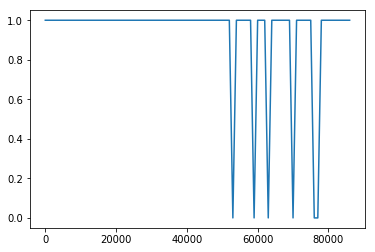

In [11]:
plt.plot(df_norm_step1000.index,
         df_norm_step1000["Attack"])

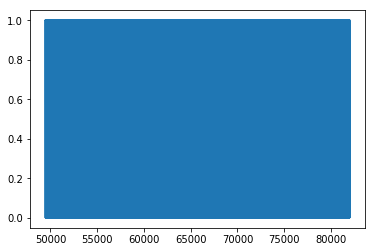

In [13]:
plt.plot(df_norm_attackperiod.index,
         df_norm_attackperiod["Attack"])

Pickle the result.

In [56]:
path = PickledDir + "df_norm_step20.pkl"
fd = open(path, "wb")
pkl.dump(df_norm_step20, fd)
fd.close()

In [57]:
path = PickledDir + "df_norm_step100.pkl"
fd = open(path, "wb")
pkl.dump(df_norm_step100, fd)
fd.close()

In [58]:
path = PickledDir + "df_norm_step1000.pkl"
fd = open(path, "wb")
pkl.dump(df_norm_step1000, fd)
fd.close()

## Calculate Cross Correlation Matrix (CCM)

Calculate the cross correlation matrix on a sliding time window and append the contents of the ccm to the signal data.

In [114]:
def mycorrelate(ar_signals, normalized = False):
    
    # initialize cross correlation matrix with zeros
    nrows = ar_signals.shape[0]    
    ccm = np.zeros(shape=(nrows, nrows), dtype=list)
    
    for i, outer_row in enumerate(ar_signals):
        for j, inner_row in enumerate(ar_signals): 

            if(not normalized):
                x = np.correlate(inner_row, outer_row) 
            else: 
                len_inner = int(len(inner_row))
                mean_inner = np.mean(inner_row)
                std_inner = np.std(inner_row)
                a = (inner_row - mean_inner) / (std_inner * len_inner) 
                b = (outer_row - np.mean(outer_row)) / (
                     np.std(outer_row)) 
                x = np.correlate(a, b) 
                    
            ccm[i][j] = x[0] 
            
    return ccm

**concat_ccm**

* Look ahead the number of time slices specified in window parameter _win_ 
* Take the cross correlation matrix (CCM) in the window of all signals.
* Flatten each CCM into a single (nested 2D) list
* Each row will have a flatted CCM. Store it in the **sigccm** column.

In [115]:
#############################################################
# concat_ccm: 
# Description: Takes DataFrame of signals as input 
# and concatenates a flattened ccm onto each row,
# but unlike prior version of this routine, concat_ccm
# will save the results at regular intervals as a precaution.
#############################################################

def concat_ccm(df, win, batchID, batch_size):

    DataDir = "data/"
    BatchDir = DataDir + batchID + "/"    

    # If directory does not already exist
    # for this batch, create it.
    if not os.path.isdir(BatchDir):
        mkdir(BatchDir)    
    
    result = []    
    width = df.shape[1]
    length = df.shape[0]
    
    # Isolate signal columns in order to calculate CCM
    value_cols = list(df.columns)
    value_cols.remove("local_time")
    value_cols.remove("Attack")
    
    df_values = df[value_cols]
    
    # Cross correlation matrix (ccm) will be a 
    # square matrix of dimensions (win X win)
    
    # Length of augmented row will be:
    #    length of current row + flattened ccm (win X win)    
    # First win-1 rows will be extended by zeros
    for i in range(win - 1):
        row = list(df_values.iloc[i].values)
        zeros = np.zeros(win * win).tolist()
        result.append(row + zeros)
    
    for idx, _ in enumerate(df_values.iterrows()):
        
        if idx + win > length:
            break

        view = df_values.iloc[idx : idx + win].values        
        ccm = mycorrelate(view, normalized = True)
        
        flatmatrix = ccm.ravel().tolist()

        # Attach the flattened CCM to the **end** of the window
        # (Careful: indices change within the view)
        # Last line of view will always have index of win - 1
        concatenated_line = list(view[win - 1, :]) + flatmatrix 
        result.append(concatenated_line)
        
        if idx != 0 and idx % batch_size == 0:
            
            fnm = 'df_{:s}_id{:d}.pkl'.format(batchID, idx)
            
            df_view = df.iloc[0 : idx + win].copy()        
            df_view["sigccm"] = pd.Series(result).values

            df_view["sigccm"] = df_view.sigccm.apply(
                                   lambda x: [list(x)])
    
            # reindex output DataFrame
            df_view.index = range(len(df_view))

            path = BatchDir + fnm
            fd = open(path, "wb")
            pkl.dump(df_view, fd)
            fd.close()

    df_augmented = df.copy()
    df_augmented["sigccm"] = pd.Series(result).values
    
    # Column "sigccm" now contains list elements.
    # Encapsulate each list element with an extra set
    # of list brackets to set the stage for creating
    # a list of lists that represents the time steps
    # of an LSTM
    
    df_augmented["sigccm"] = df_augmented.sigccm.apply(
                                    lambda x: [list(x)])

    # reindex output DataFrame
    df_augmented.index = range(len(df_augmented))
    
    return df_augmented, result

Generate SigCCM Training Data

In [ ]:
df_augmented, res = concat_ccm(df_norm_attackperiod, 
                          win = 100,
                          batchID = "norm_attack",
                          batch_size = 1000)

Generate SigCCM Test Data

In [116]:
df_attack_5000to6000 = df_norm_attackperiod[5000:6000]

In [117]:
df_augmented, res = concat_ccm(df_attack_5000to6000, 
                          win = 100,
                          batchID = "norm_attack",
                          batch_size = 1000)

## Store SigCCM Data in HDF5

Store SigCCM training data.

For now, `add_time_steps_df()`, requires a DataFrame input. It can't read directly from an HDF5 data store, so this step can be skipped. 

In [142]:
df_attack_id5000.shape 

(5100, 91)

In [143]:
df = df_attack_id5000
dataID = "attack_id5000"
h5path = store_series_of_lists_in_h5file(df, dataID, 
                                         "sigccm", "Attack")

'data/attack_id5000/attack_id5000.h5'

In [162]:
pd.DataFrame(sigccm[0]).shape

(1, 10088)

In [154]:
a = extracth5toarray(h5path, "sigccm")

In [155]:
a.shape

(5100, 1, 10088)

Store SigCCM test data.

In [125]:
# df_attack_5000to6000.head()
# df_augmented.head()

In [123]:
df = df_augmented
dataID = "attack_5000to6000"
h5path = store_series_of_lists_in_h5file(df, dataID, 
                                         "sigccm", "Attack")

## Shape Data for LSTM Input

Just as we had a lookahead window for purposes of calculating the CCM, likewise, we now calculate a moving lookahead window to create LSTM time steps.

**DataFrame Input**

In [127]:
def add_time_steps_df(df, win = 3):

    sigccm = df["sigccm"].copy()
    
    # Calculate the length of the list elements
    # so we'll know how big the padding has to be
    listlen = len(df["sigccm"][0][0])
    padding = list(np.repeat(0, listlen))
    
    if win < 2:
        return sigccm
    
    # # First merge requires slightly different syntax
    # # in call to combine method
    # s = df["sigccm"].apply(lambda x: x[0]).shift(-1).fillna(0)
    # sigccm = sigccm.combine(s, lambda x1, x2: x1 + [x2])
    # 
    # if win < 3:
    #     return sigccm
    
    # Subsequent merges
    for i in range(1, win):
        
        s = df["sigccm"].apply(
            lambda x: x[0]).shift(-i).fillna(0)
            
        sigccm = sigccm.combine(s, lambda x1, x2: x1 + [x2])
    
    df["sigccm"] = sigccm

    return df

Add time steps to training data.

In [5]:
df_attack_id5000["sigccm"] = df_attack_id5000.sigccm.apply(
                                lambda x: [list(x)]) 

In [166]:
df_rows_5000_ccm_100_lstm_100 = add_time_steps_df(
    df_attack_id5000, win = 100)

Add time steps to test data.

In [128]:
df_rows_5000to6000_ccm_100_lstm_100 = add_time_steps_df(
    df_augmented, win = 100)

Time steps have been added. Store the results for the training data.

In [265]:
df = df_rows_5000_ccm_100_lstm_100
dataID = "rows_5000_ccm_100_lstm_100"
h5path = store_series_of_lists_in_h5file(df, dataID, 
                                         "sigccm", "Attack") 

Mismatch with element 5001:

chunkshape = (100, 10088)
Mismatch with element 5002:

chunkshape = (100, 10088)
Mismatch with element 5003:

chunkshape = (100, 10088)
Mismatch with element 5004:

chunkshape = (100, 10088)
Mismatch with element 5005:

chunkshape = (100, 10088)
Mismatch with element 5006:

chunkshape = (100, 10088)
Mismatch with element 5007:

chunkshape = (100, 10088)
Mismatch with element 5008:

chunkshape = (100, 10088)
Mismatch with element 5009:

chunkshape = (100, 10088)
Mismatch with element 5010:

chunkshape = (100, 10088)
Mismatch with element 5011:

chunkshape = (100, 10088)
Mismatch with element 5012:

chunkshape = (100, 10088)
Mismatch with element 5013:

chunkshape = (100, 10088)
Mismatch with element 5014:

chunkshape = (100, 10088)
Mismatch with element 5015:

chunkshape = (100, 10088)
Mismatch with element 5016:

chunkshape = (100, 10088)
Mismatch with element 5017:

chunkshape = (100, 10088)
Mismatch with element 5018:

chunkshape = (100, 10088)
Mismatch w

In [219]:
h5path

'data/rows_5000_ccm_100_lstm_100/rows_5000_ccm_100_lstm_100.h5'

Time steps have been added. Store the results for the test data.

In [129]:
df = df_rows_5000to6000_ccm_100_lstm_100
dataID = "rows_5000to6000_ccm_100_lstm_100"
h5path = store_series_of_lists_in_h5file(df, dataID, 
                                         "sigccm", "Attack")

Mismatch with element 901:

chunkshape = (100, 10088)
Mismatch with element 902:

chunkshape = (100, 10088)
Mismatch with element 903:

chunkshape = (100, 10088)
Mismatch with element 904:

chunkshape = (100, 10088)
Mismatch with element 905:

chunkshape = (100, 10088)
Mismatch with element 906:

chunkshape = (100, 10088)
Mismatch with element 907:

chunkshape = (100, 10088)
Mismatch with element 908:

chunkshape = (100, 10088)
Mismatch with element 909:

chunkshape = (100, 10088)
Mismatch with element 910:

chunkshape = (100, 10088)
Mismatch with element 911:

chunkshape = (100, 10088)
Mismatch with element 912:

chunkshape = (100, 10088)
Mismatch with element 913:

chunkshape = (100, 10088)
Mismatch with element 914:

chunkshape = (100, 10088)
Mismatch with element 915:

chunkshape = (100, 10088)
Mismatch with element 916:

chunkshape = (100, 10088)
Mismatch with element 917:

chunkshape = (100, 10088)
Mismatch with element 918:

chunkshape = (100, 10088)
Mismatch with element 919:



In [130]:
h5path

'data/rows_5000to6000_ccm_100_lstm_100/rows_5000to6000_ccm_100_lstm_100.h5'

Miscellaneous info about shape of data.

In [167]:
df_rows_5000_ccm_100_lstm_100.shape

(5100, 91)

In [173]:
sigccm = df_rows_5000_ccm_100_lstm_100["sigccm"]

In [174]:
pd.DataFrame(sigccm[0]).shape

(100, 10088)

In [213]:
pd.DataFrame(df["Attack"]).shape

(5100, 1)

In [261]:
attack2 = df_rows_5000_ccm_100_lstm_100["Attack"]

In [262]:
attack2.shape

(5100,)

In [263]:
attack2[0]

1.0

## Pandas IO Tools

* [Pandas IO Tools](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html) 

**Storing huge 2D lists**

In [ ]:
# df = df_rows_5000_ccm_100_lstm_100.copy()

In [5]:
sigccm = df["sigccm"]

In [7]:
sigccm.head()

0    [[0.5943655, 0.9374445, 0.4947335, 0.389245, 0...
1    [[0.5943655, 0.9374445, 0.4950527, 0.37161678,...
2    [[0.5943655, 0.9374445, 0.5639962, 0.65135324,...
3    [[0.5943655, 0.9374445, 0.51292694, 0.37143874...
4    [[0.5943655, 0.9374445, 0.49792534, 0.41417378...
Name: sigccm, dtype: object

In [21]:
list2D = sigccm[0]

In [14]:
type(list2D)

list

In [13]:
pd.DataFrame(list2D).shape

(100, 10088)

**Save 2D List with HD**

Attempt to save it as a list. Fails with error: 

    TypeError: cannot properly create the storer for: [_TYPE_MAP] [group->/biglist (Group) '',value-><class 'list'>,format->table,append->True,kwargs->{'encoding': None, 'dropna': False}]

In [15]:
>> store = pd.HDFStore("junkBig2DList", mode = 'w')
>> store.append("biglist", list2D) 

Attempt to save it as an array. Fails with error:

    TypeError: cannot properly create the storer for: [_TYPE_MAP] [group->/biglist (Group) '',value-><class 'numpy.ndarray'>,format->table,append->True,kwargs->{'encoding': None, 'dropna': False}]

In [22]:
array2D = np.array(list2D)
array2D.shape

(100, 10088)

In [ ]:
>> store = pd.HDFStore("junkBig2DList", mode = 'w')
>> store.append("biglist", array2D)

Attempt to save it as a dataframe **_also_** fails with the error:

    End of HDF5 error back trace. Can't set attribute 'non_index_axes' in node:  /biglist (Group) ''.
    
Apparently, this occurs because the HDF5 format allows for a maximum of 2,000 columns. This [StackOverflow forum post](https://stackoverflow.com/questions/16639503/unable-to-save-dataframe-to-hdf5-object-header-message-is-too-large) explains:

> HDF5 has a header limit of 64kb for all metadata of the columns. This include name, types, etc. When you go about roughly 2000 columns, you will run out of space to store all the metadata. This is a fundamental limitation of pytables. I don't think they will make workarounds on their side any time soon. You will either have to split the table up or choose another storage format.

In [25]:
df2D = pd.DataFrame(list2D)
df2D.shape

(100, 10088)

In [29]:
df2D[:2]

,0,1,2,3,4,5,6,7,8,9,...,10078,10079,10080,10081,10082,10083,10084,10085,10086,10087
0,0.594365,0.937445,0.494734,0.389245,0.414776,0.394848,0.478838,0.555175,0.573013,0.608837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.594365,0.937445,0.495053,0.371617,0.397884,0.377382,0.479147,0.555578,0.573383,0.608837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# This fails:
>> store = pd.HDFStore("junkBig2DList", mode = 'w')
>> store.append("biglist", df2D)

In [36]:
store.close()

<font color="blue">**However, as explained by one of the comments in the StackOverflow forum, if you specify fixed format, it works!**</font>

In [32]:
df2D.to_hdf("junkBig2DList",'biglist',format='f')

In [33]:
df2D_imported = pd.read_hdf("junkBig2DList",'biglist')

In [35]:
df2D_imported[:2]

,0,1,2,3,4,5,6,7,8,9,...,10078,10079,10080,10081,10082,10083,10084,10085,10086,10087
0,0.594365,0.937445,0.494734,0.389245,0.414776,0.394848,0.478838,0.555175,0.573013,0.608837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.594365,0.937445,0.495053,0.371617,0.397884,0.377382,0.479147,0.555578,0.573383,0.608837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Saving a huge 2D list using `h5py`.

Try chunking as described in [this article](https://www.oreilly.com/library/view/python-and-hdf5/9781491944981/ch04.html).

In [ ]:
>>> f = h5py.File("imagetest.hdf5")
>>> dset = f.create_dataset("Images", (100, 480, 640), dtype='uint8')
>>> dset = f.create_dataset('chunked', 
                            (100,480,640), 
                             dtype='i1', 
                             chunks=(1,64,64))

In [80]:
f = h5py.File("junkBig2DList.h5") 

In [81]:
dset = f.create_dataset('biglist', (5000,100,10000), 
                             dtype='f', 
                             chunks=(1,100,10000))

In [82]:
pd.DataFrame(list2D).shape

(100, 10088)

In [83]:
a = np.array(list3D)
b = np.resize(a, (1, 100, 10000))
b.shape

(1, 100, 10000)

Here we successfully assign a (100, 10000) array to the first 3 elements of the dataset.

In [84]:
dset[0] = b
dset[1] = b
dset[2] = b

In [85]:
f.close()

Unfortunately, you can't open the dataset with `read_hdf`

`pd_file = pd.read_hdf('junkBig2DList.h5', 'biglist')`

    TypeError: cannot create a storer if the object is not existing nor a value are passed

But if you open it with `h5py` in read mode, you can then extract the dataset (array) elements one at a time.

In [88]:
f = h5py.File('junkBig2DList.h5', 'r')

In [89]:
list(f.keys())

['biglist']

In [90]:
x = f["biglist"]

In [92]:
type(x), x.shape

(h5py._hl.dataset.Dataset, (5000, 100, 10000))

In [95]:
z = x[0]
type(z), z.shape

(numpy.ndarray, (100, 10000))

**Save 3D List with PyArrow**

### HDF5 Files

* [Pandas IO Tools](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html) 
* [Chunking with HDF5 Datasets](https://www.oreilly.com/library/view/python-and-hdf5/9781491944981/ch04.html)
* [How to store a very large 3 dimensional matrix in HDF5 format](https://stackoverflow.com/questions/42053308/how-to-store-very-large-3-dimensional-matrix-in-hdf5-format)
* [How to use HDF5 files in Python](https://www.pythonforthelab.com/blog/how-to-use-hdf5-files-in-python/)
* [The Blaze Ecosystem](http://blaze.pydata.org/)
* [Using pandas with large datasets](https://www.dataquest.io/blog/pandas-big-data/)
* [How to save and load large pandas dataframes.
](https://metarabbit.wordpress.com/2013/12/10/how-to-save-load-large-pandas-dataframes/)
* [Efficiently Store Pandas DataFrames](http://matthewrocklin.com/blog/work/2015/03/16/Fast-Serialization)
* [pandas HDFStore - how to reopen?](https://stackoverflow.com/questions/14591855/pandas-hdfstore-how-to-reopen/24608109) 
* [HDFStore appending for mixed datatypes](https://github.com/pandas-dev/pandas/issues/3032) 
* [Storing Padas objects along with regular Python objects in HDF5](https://stackoverflow.com/questions/17820071/storing-pandas-objects-along-with-regular-python-objects-in-hdf5) 
* [Pandas Cookbook - HDFStore](https://pandas.pydata.org/pandas-docs/stable/user_guide/cookbook.html) 
  * Managing heterogeneous data
  * Creating a store chunk-by-chunk from a CSV file
  * Appending to a store, while creating a unique index
* [Append large amounts of data to HDFStore with unique index](https://stackoverflow.com/questions/16997048/how-does-one-append-large-amounts-of-data-to-a-pandas-hdfstore-and-get-a-natural) 
* [Pickle dump huge file without memory error - klepto, hinkle](https://stackoverflow.com/questions/17513036/pickle-dump-huge-file-without-memory-error) 
* [Large data work flows using pandas](https://stackoverflow.com/questions/14262433/large-data-work-flows-using-pandas) 
* [How to store a dataframe using pandas](https://stackoverflow.com/questions/17098654/how-to-store-a-dataframe-using-pandas)

In [61]:
x_junk1 = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
x_junk2 = np.array([[11, 12, 13], [14, 15, 16], [17, 18, 19]])
x_junk3 = np.array([[21, 22, 23], [24, 25, 26], [27, 28, 29]])

df_junk1 = pd.DataFrame(x_junk1, columns = ["A", "B", "C"])
df_junk2 = pd.DataFrame(x_junk2, columns = ["A", "B", "C"])
df_junk3 = pd.DataFrame(x_junk3, columns = ["A", "B", "C"])

df_junk1

,A,B,C
0,1,2,3
1,4,5,6
2,7,8,9


In [60]:
store = pd.HDFStore("junk2", mode = 'w')

In [43]:
store.append("junk1", df_junk1)
store.append("junk2", df_junk2)
store.append("junk3", df_junk3)

In [59]:
store.close()

In [46]:
df = pd.read_hdf("junk", "junk3")

In [47]:
df

,A,B,C
0,21,22,23
1,24,25,26
2,27,28,29


Assign to an HDStore attribute.

In [4]:
# THIS DOESN'T WORK
# store.get_storer("trash1").attrs.my_attribute = x_junk1 

Test with Torgi data.

In [40]:
df_2rows = data.iloc[:2].copy()

In [32]:
# store.put("junk", x_junk1, table = True)
# store.put("junk", df_junk, table = True)

In [4]:
store = pd.HDFStore("garbage1")

In [6]:
df1 = pd.DataFrame(["g1"], columns = ["id"])
df1

,id
0,g1


In [10]:
store.append("batch1", df1)

In [7]:
x_junk1 = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

In [11]:
store.get_storer("batch1").attrs.my_attribute = x_junk1

In [12]:
list(store)

['/batch1']

In [14]:
store['batch1'].shape

(1, 1)

In [17]:
# store['batch1'].attrs <<< ERROR
store.close()

In [16]:
import h5py

In [18]:
f = h5py.File("garbage1")

In [26]:
list(f.keys()), list(f.values())

(['batch1'], [<HDF5 group "/batch1" (2 members)>])

In [25]:
# list(f["batch1"].attrs) << THIS WORKS, lists all attributes

In [24]:
f["batch1"].attrs["my_attribute"]

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [27]:
group1 = f.create_group("group1")

In [28]:
group1.name

'/group1'

In [29]:
list(group1)

[]

In [31]:
# f.get_storer("group1").attrs.my_attribute = x_junk1 <<< ERROR

In [35]:
group1.attrs.items()

ItemsViewHDF5(<Attributes of HDF5 object at 140564480995176>)

In [36]:
group1.attrs.create("attrib1", x_junk1)

In [37]:
x = group1.attrs.get("attrib1")

In [38]:
x

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [41]:
z = np.random.rand(100, 100)

In [42]:
# w = z.ravel().tolist()
w = z.ravel()
w

array([0.27101293, 0.45711131, 0.82391123, ..., 0.10666072, 0.52993864,
       0.15903336])

In [44]:
# group1.attrs.create("attrib2", w) <<< COMPLAINS w too large

Datasets look promising.

In [42]:
f.close()

In [43]:
f = h5py.File("garbage4")

In [44]:
dataset = f.create_dataset("bigdata4", 
                            shape=(1, 10000), 
                            dtype=np.float64)

In [45]:
type(dataset)

h5py._hl.dataset.Dataset

In [46]:
x4 = f["bigdata4"] 

In [47]:
x4.shape, type(x4)

((1, 10000), h5py._hl.dataset.Dataset)

In [48]:
a4 = f["bigdata4"][()]

In [49]:
type(a4), a4.shape

(numpy.ndarray, (1, 10000))

In [50]:
a4

array([[0., 0., 0., ..., 0., 0., 0.]])

In [51]:
x2 = np.random.rand(10000)
type(x2), x2.shape

(numpy.ndarray, (10000,))

In [52]:
x2[:3]

array([0.19308598, 0.13214827, 0.58452798])

In [53]:
f["bigdata4"][:3]

array([[0., 0., 0., ..., 0., 0., 0.]])

In [17]:
# f["bigdata1"] = x2 <<< gives and ERROR

In [19]:
# f["bigdata1"].append(x2) <<< gives and ERROR

In [54]:
dataset[0] = x2

In [55]:
dataset.shape

(1, 10000)

In [56]:
dataset

<HDF5 dataset "bigdata4": shape (1, 10000), type "<f8">

In [94]:
DataDir = "data/"
SubDir = "lstm_ready/"
DirPath = DataDir + SubDir
hdf5file = "attack_rows_5000_ccm_100_lstm_100"
fnm = DirPath + hdf5file

In [122]:
# store = pd.HDFStore("garbagetest0", mode = 'w')
# store.append("data", sigccm.values)

In [107]:
# df_attack_rows_5000_ccm_100_lstm_100.to_hdf(
#     'test.h5', 'data', format='table')

In [97]:
# drop localtime because it's an integer and HDF5 doesn't
# like that for some reason
df = df_attack_rows_5000_ccm_100_lstm_100.drop(
                            ["local_time"], axis = 1)

In [108]:
# f = h5py.File(fnm)
# store = pd.HDFStore(fnm, mode = 'w')
# store.append(hdf5file, df)

In [10]:
# df_attack_id5000.info(memory_usage='deep')

### PyArrow and Parque Files

* [Pandas Integration](https://arrow.apache.org/docs/python/pandas.html#pandas-integration)
* [Reading and Writing the Apache Parquet Format](https://arrow.apache.org/docs/python/parquet.html)

In [17]:
import pyarrow as pa

In [12]:
# from pyarrow import parque as pq
import pyarrow.parquet as pq

In [14]:
table = pa.Table.from_pandas(df3)

In [17]:
pq.write_table(table, 'parquet.example1')

In [18]:
table2 = pq.read_table('parquet.example1')

In [15]:
df4 = table.to_pandas()

In [19]:
df5 = table2.to_pandas()

### IO Routines

In [204]:
def extracth5toarray(h5path, dataID):
    f = h5py.File(h5path)
    s = f[dataID]
    return np.array(s)

In [119]:
def store_series_of_lists_in_h5file(df, dataID, colID1 = None, 
                                                colID2 = None):
    
    DataDir = "data/"
    DataDir = DataDir + dataID + "/"  
    
    # If directory does not already exist
    # for this batch, create it.
    if not os.path.isdir(DataDir):
        mkdir(DataDir)

    col1 = df[colID1]
    col2 = df[colID2]
    
    # get the dimensions of 
    length = len(col1)
    col1_x, col1_y = np.array(col1[0]).shape
    # col2_x, col2_y = np.array(col2).shape
    
    path = DataDir + dataID + ".h5"
    f = h5py.File(path) 
    
    if colID1 != None:
        dataset1 = f.create_dataset(colID1, (length, col1_x, col1_y), 
                                     dtype='f', 
                                     chunks=(1, col1_x, col1_y))    

    if colID2 != None:        
        dataset2 = f.create_dataset(colID2, (length,), 
                                     dtype='f', 
                                     chunks=(1,))          
    
    chunkshape1 = (col1_x, col1_y)
    # chunkshape2 = (col2_x, col2_y)
    for i, row in enumerate(col1):
        shape1 = np.array(col1[i]).shape
        # shape2 = np.array(col2[i]).shape
        # if shape1 != chunkshape1 and shape2 != chunkshape2:
        if shape1 != chunkshape1:    
            print("Mismatch with element %d:\n" % (i))
            print("chunkshape = %s" % str(chunkshape1)) 
            continue
        else:
            dataset1[i] = col1[i]
            dataset2[i] = col2[i]

    f.close()
    
    return path     

## Save Pickled Files

In [ ]:
PickledDir = "Pickled Files/"

In [ ]:
path = PickledDir + "df_signals.pkl"
fd = open(path, "wb")
pkl.dump(df_signals, fd)
fd.close()

In [155]:
path = PickledDir + "df_signals_ccm.pkl"
fd = open(path, "wb")
pkl.dump(df_signals_ccm, fd)
fd.close()

In [19]:
path = PickledDir + "df_rows_2000_ccm_100.pkl"
fd = open(path, "wb")
pkl.dump(df_rows_2000_ccm_100, fd)
fd.close()

In [11]:
# This throws a Memory error:
#
# PickledDir = "Pickled Files/"
# path = PickledDir + "df_attack_rows_5000_ccm_100_lstm_100.pkl"
# fd = open(path, "wb")
# pkl.dump(df_attack_rows_5000_ccm_100_lstm_100, fd)
# fd.close()

### Save to Dill File

In [ ]:
import dill

PickledDir = "Pickled Files/"
path = PickledDir + "df_attack_rows_5000_ccm_100_lstm_100.dill"
fd = open(path, "wb")
dill.dump(df_attack_rows_5000_ccm_100_lstm_100, fd)
fd.close()

### Save to HDF5 File

In [ ]:
DataDir = "data/rows_5000_ccm_100_lstm_100/"

In [12]:
fnm = "rows_5000_ccm_100_lstm_100.h5"
path = DataDir + fnm

**Using a DataFrame method**

In [ ]:
store = pd.HDFStore(path)
store.is_open

`store.put()` warns that performance might suffer, because PyTables is just going to pickle the objects (i.e. may as well use Pickle).

In [65]:
>> store.put('df', df_rows_5000_ccm_100_lstm_100)

In [16]:
store.close()

**Using `h5py`**

In [98]:
df = df_rows_5000_ccm_100_lstm_100.head()

### Save to PyArrow-Parquet File

In [12]:
df_rows_5000_ccm_100_lstm_100.dtypes

local_time     object
Attack         object
agc_001       float32
agc_002       float32
agc_003       float32
agc_004       float32
agc_005       float32
agc_006       float32
agc_007       float32
agc_008       float32
agc_009       float32
agc_010       float32
agc_011       float32
agc_012       float32
agc_013       float32
agc_014       float32
agc_015       float32
agc_016       float32
agc_017       float32
agc_018       float32
agc_019       float32
agc_020       float32
agc_021       float32
agc_022       float32
agc_023       float32
agc_024       float32
agc_025       float32
agc_026       float32
agc_027       float32
agc_028       float32
               ...   
cn0_016       float32
cn0_017       float32
cn0_018       float32
cn0_019       float32
cn0_020       float32
cn0_021       float32
cn0_022       float32
cn0_023       float32
cn0_024       float32
cn0_025       float32
cn0_026       float32
cn0_027       float32
cn0_028       float32
cn0_029       float32
cn0_030   

In [14]:
sigccm = df_rows_5000_ccm_100_lstm_100["sigccm"]

In [15]:
sigccm.dtype

dtype('O')

In [16]:
df = df_rows_5000_ccm_100_lstm_100.copy()

In [ ]:
df["sigccm"] = df.sigccm.apply(lambda x: np.array(x)) 

In [17]:
table = pa.Table.from_pandas(df_rows_5000_ccm_100_lstm_100)
pq.write_table(table, 'parquet.example1')
table2 = pq.read_table('parquet.example1')
df4 = table.to_pandas() 
df5 = table2.to_pandas()

## Load Files

### Load from Pickled Files

In [3]:
PickledDir = "Pickled Files/"

**Raw data** (after some cleaning).

In [7]:
path = PickledDir + "df_jamming.pkl"
fd = open(path, "rb")
df_jamming = pkl.load(fd)
fd.close()

**Data after each phone's signal data has been assigned a column**.

In [4]:
path = PickledDir + "df_signals.pkl"
fd = open(path, "rb")
df_signals = pkl.load(fd)
fd.close()

**Data after signals have been normalized**.

In [4]:
PickledDir = "Pickled Files/"
path = PickledDir + "df_norm.pkl"
fd = open(path, "rb")
df_norm = pkl.load(fd)
fd.close()

**Data for time period in which jamming occurred**.

In [113]:
PickledDir = "Pickled Files/"
path = PickledDir + "df_norm_attackperiod.pkl"
fd = open(path, "rb")
df_norm_attackperiod = pkl.load(fd)
fd.close()

**Data after column with CCM matrix has been added**.

In [102]:
DataDir = "data/attack_period1/"
path = DataDir + "df_attack_id5000.pkl"
fd = open(path, "rb")
df_attack_id5000 = pkl.load(fd)
fd.close()

In [103]:
df_attack_id5000.shape

(5100, 91)

`df_attack_id5000` was saved without the proper nesting of the data in `sigccm`. Fix that problem.

In [106]:
df_attack_id5000["sigccm"] = df_attack_id5000.sigccm.apply(
                                lambda x: [list(x)])

**Data after LSTM time steps have been added**.

In [62]:
PickledDir = "Pickled Files/"
path = PickledDir + "df_lstm_100_rows_2000_ccm_100.pkl"
fd = open(path, "rb")
df_lstm_100_rows_2000_ccm_100 = pkl.load(fd)
fd.close()

### Load from HDF5 File

In [3]:
DataDir = "data/rows_5000_ccm_100_lstm_100/"
hdf5_fnm = DataDir + "rows_5000_ccm_100_lstm_100.h5"

Read HDF5 data with DataFrame method.

In [4]:
df = pd.read_hdf(hdf5_fnm)
df_rows_5000_ccm_100_lstm_100 = df

Read HDF5 data with `h5py`.

In [67]:
f = h5py.File(hdf5_fnm)

In [69]:
df = f["df"]

### Load from PyArrow-Parquet File

In [7]:
df = df_rows_5000_ccm_100_lstm_100.copy()

In [ ]:
for i, e in enumerate(df.iterrows()):
    df["sigccm"].iloc[i] = np.array(df["sigccm"].iloc[i])

/home/john/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Data Generator

## Generator in a Python Class

**Using Python Class `getitem` as Generator**

In [4]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, batchID, 
                 batch_size = 32, 
                 dim = (32,32,32)):

        self.dim = dim
        self.batch_size = batch_size
        self.datafile_IDs = []
        self.labelfile_IDs = []
        self.batchID = batchID    
        self.DataDir = "data/"
        self.BatchDir = ""
        
        DataDir = self.DataDir
        BatchDir = DataDir + batchID + "/"
        self.BatchDir = BatchDir
        
        path = BatchDir + "datafilenames_" + batchID + ".pkl"                                    
        fd = open(path, "rb")
        self.datafile_IDs = pkl.load(fd)
        fd.close()
        
        path = BatchDir + "labelfilenames_" + batchID + ".pkl"        
        fd = open(path, "rb")
        self.labelfile_IDs = pkl.load(fd)
        fd.close()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(
            np.floor(len(self.datafile_IDs) / self.batch_size))

    def __getitem__(self, index):
        
        'Generate one batch of data'
        
        datafn = self.datafile_IDs[index]        
        labelfn = self.labelfile_IDs[index]  
        
        print("In getitem: index = %d, datafn = %s, labelfn = %s" % (
               index, datafn, labelfn))

        batch_size = self.batch_size
        
        # Initialize data arrays for this batch     
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)         

        BatchDir = self.BatchDir

        # Read data
        datafn = BatchDir + datafn
        X = np.load(datafn)

        # Read label
        labelfn = BatchDir + labelfn
        y = np.load(labelfn)
        
        return X, y        

In [6]:
df_input = df_lstm_100_rows_2000_ccm_100
df_short = df_input[100:200].copy()
df_test = df_input[200:300].copy()

In [7]:
genbatchfiles(df_short, batchID = "short", batch_size = 20)

In [8]:
params = {'batchID': "short", 'batch_size': 20, 'dim': (100, 10088)}

In [10]:
dg = DataGenerator(**params)

**Older, More Complicated Version of Class-Style Generator**

In [4]:
def savedata(df, batchID, recs_per_id = 5):

    DataDir = "data/"
    BatchDir = DataDir + batchID + "/"
    
    # If directory does not already exist
    # for this batch, create it.
    if not os.path.isdir(BatchDir):
        mkdir(BatchDir)

    sigccm = df["sigccm"]
    attack = df["Attack"]
        
    idcnt = 0
    datafiles = []
    labelfiles = []
    
    # number of records to process
    nrecs = len(sigccm)
    
    for i in range(0, nrecs, recs_per_id):
        
        if i + recs_per_id > nrecs:
            upperbound = nrecs 
        else: 
            upperbound = i + recs_per_id
        
        x = np.stack(sigccm[i : upperbound]) 
        y = np.stack(attack[i : upperbound]) 
        
        fnm = 'data_{:s}{:02d}.npy'.format(batchID, idcnt)
        datafiles.append(fnm)        
        np.save(BatchDir + fnm, x)
        
        fnm = 'labels_{:s}{:02d}.npy'.format(batchID, idcnt)
        labelfiles.append(fnm)        
        np.save(BatchDir + fnm, y)
        
        idcnt = idcnt + 1
        
    path = BatchDir + "datafilenames_" + batchID + ".pkl"
    
    fd = open(path, "wb")
    pkl.dump(datafiles, fd)
    fd.close() 

    path = BatchDir + "labelfilenames_" + batchID + ".pkl"
    
    fd = open(path, "wb")
    pkl.dump(labelfiles, fd)
    fd.close()    

In [5]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, batchID, batch_size=32, 
                 dim=(32,32,32), shuffle = False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.datafile_IDs = []
        self.labelfile_IDs = []
        self.batchID = batchID    
        self.DataDir = "data/"
        self.BatchDir = ""
        self.shuffle = shuffle
        # self.on_epoch_end() 
        
        DataDir = self.DataDir
        BatchDir = DataDir + batchID + "/"
        self.BatchDir = BatchDir
        
        path = BatchDir + "datafilenames_" + batchID + ".pkl"                                    
        fd = open(path, "rb")
        self.datafile_IDs = pkl.load(fd)
        fd.close()
        
        path = BatchDir + "labelfilenames_" + batchID + ".pkl"        
        fd = open(path, "rb")
        self.labelfile_IDs = pkl.load(fd)
        fd.close()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(
            np.floor(len(self.datafile_IDs) / self.batch_size))

    def __getitem__(self, index):
        
        'Generate one batch of data'
        
        # Find file names for the batch   
        
        # Here "batch size" = Number of files we read in for
        # each element (index value) of the DataGenerator object
        batch_size = self.batch_size
        datafile_IDs = self.datafile_IDs[
             index * batch_size : (index + 1) * batch_size]        
        labelfile_IDs = self.labelfile_IDs[
             index * batch_size : (index + 1) * batch_size]        
        
        # Generate data
        X, y = self.__data_generation(datafile_IDs, labelfile_IDs)

        return X, y

    # def on_epoch_end(self):
    #     'Updates indexes after each epoch'
        # self.indexes = np.arange(len(self.list_IDs))
        # if self.shuffle == True:
        #     np.random.shuffle(self.indexes)
    #    print("Call to routine on_epoch_end()")

    def __data_generation(self, datafile_IDs, labelfile_IDs):
        
        'Generates data containing batch_size samples' 
        
        BatchDir = self.BatchDir
        
        # X : (n_samples, *dim, n_channels)
        
        # Initialize data arrays for this batch     
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)         
        
        data_arrays = []
        label_arrays = []
        
        # Generate data
        for datafn, labelfn in zip(datafile_IDs, labelfile_IDs):
            
            # Store data
            datafn = BatchDir + datafn
            dat = np.load(datafn)
            data_arrays.append(dat)

            # Store label
            labelfn = BatchDir + labelfn
            lbl = np.load(labelfn)
            label_arrays.append(lbl)

        X = np.vstack(data_arrays)
        y = np.vstack(label_arrays)
        
        return X, y        

In [6]:
df_input = df_lstm_100_rows_2000_ccm_100

In [7]:
df_short200 = df_input[100:300].copy()
df_test = df_input[300:400].copy()

In [8]:
batchID = "short200"

savedata(df_short200, batchID, recs_per_id = 5)

In [9]:
# pd.DataFrame(sigccm[0]).shape
# (100, 10088)
params = {'dim': (100, 10088),
          'batch_size': 10,
          'shuffle': False}
params

{'batch_size': 10, 'dim': (100, 10088), 'shuffle': False}

In [10]:
dg = DataGenerator(batchID = "short", **params)

In [11]:
X, y = dg[0]

In [12]:
X.shape

(20, 100, 10088)

**Boneyard**

In [85]:
def genbatchhd5(df, batchID, batch_size):

    DataDir = "data/"
    BatchDir = DataDir + batchID + "/"
    
    # If directory does not already exist
    # for this batch, create it.
    if not os.path.isdir(BatchDir):
        mkdir(BatchDir)

    sigccm = df["sigccm"]
    attack = df["Attack"]
        
    idcnt = 0

    # number of records to process
    nrecs = len(sigccm)
    print("Number of records: %d" % nrecs)    
    
    nbatches = np.floor(nrecs / batch_size)
    
    f = h5py.File(BatchDir + batchID + ".h5")    
    dataset_data = f.create_dataset("data", 
                           shape=(nbatches, batch_size, 10000), 
                           dtype=np.float64)
    dataset_labels = f.create_dataset("labels", 
                           shape=(nbatches, batch_size, 1), 
                           dtype=np.float64)
    
    for i in range(0, nrecs, batch_size):
        
        if i + batch_size > nrecs:
            # upperbound = nrecs 
            
            # if we don't have enough records left 
            # to make a complete batch, just bail out
            break
        else: 
            upperbound = i + batch_size            
        
        x = np.stack(sigccm[i : upperbound]) 
        y = np.stack(attack[i : upperbound]) 
        
        dataset_data[idcnt] = x
        dataset_labels[idcnt] = y
        
        # fnm = 'data_{:s}{:02d}.npy'.format(batchID, idcnt)
        # dataid = 'data_{:s}{:02d}'.format(batchID, idcnt)
        # dataid = 'data_{:02d}'.format(idcnt)
        # dataids.append(dataid)        
        # hd5store.append(dataid, df_x)
        # hd5store.put(dataid, x)
        # np.save(BatchDir + fnm, x) 

        # >> store.get_storer("junk").attrs.my_attribute = x_junk1
               
        # labelid = 'labels_{:s}{:02d}'.format(batchID, idcnt)
        # labelid = 'labels_{:02d}'.format(idcnt)
        # labelids.append(labelid)        
        # hd5store.append(labelid, df_y)
        # hd5store.put(labelid, y)
        # np.save(BatchDir + fnm, y)
        
        idcnt = idcnt + 1            

    f.close()
    
    # data_ids = "dataids_" + batchID
    # label_ids = "labelids_" + batchID
    # hd5store.put(data_ids, dataids)
    # hd5store.put(label_ids, labelids)
    
    # path = BatchDir + "datafilenames_" + batchID + ".pkl"
    # 
    # fd = open(path, "wb")
    # pkl.dump(datafiles, fd)
    # fd.close() 
    # 
    # path = BatchDir + "labelfilenames_" + batchID + ".pkl"
    # 
    # fd = open(path, "wb")
    # pkl.dump(labelfiles, fd)
    # fd.close()    
    

In [78]:
df_junktest3 = df_rows_5000_ccm_100_lstm_100[:100].copy()

In [86]:
batchID = "junktest3"
DataDir = "data/"
BatchDir = DataDir + batchID + "/"
batch_size = 20

In [87]:
genbatchhd5(df_junktest3,
            batchID = batchID, 
            batch_size = batch_size)

Number of records: 100


TypeError: Can't broadcast (20, 100, 10088) -> (1, 10000)

In [57]:
data = df_recs_5000_ccm_100_lstm_100
batchID = "recs_5000_ccm_100_lstm_100"
batch_size = 200

DataDir = "data/"
hd5fnm = "recs_5000_ccm_100_lstm_100.h5"
path = DataDir + hd5fnm
hd5store = pd.HDFStore(path)

In [60]:
df_rows_2000_ccm_100_lstm_100.head()

NameError: name 'df_rows_2000_ccm_100_lstm_100' is not defined

In [49]:
dat = f.create_dataset("bigdata1", shape=(10000,), dtype=np.float64)

In [50]:
x1 = f["bigdata1"] 

In [51]:
x1.shape, type(x1)

((10000,), h5py._hl.dataset.Dataset)

In [52]:
a1 = f["bigdata1"][()]

In [53]:
type(a1), a1.shape

(numpy.ndarray, (10000,))

## Generator Based on Numpy IO

**Batch Generation Using Numpy IO**

In [9]:
def genbatchfiles(df, batchID, batch_size = 5):

    DataDir = "data/"
    BatchDir = DataDir + batchID + "/"
    
    # If directory does not already exist
    # for this batch, create it.
    if not os.path.isdir(BatchDir):
        mkdir(BatchDir)

    sigccm = df["sigccm"]
    attack = df["Attack"]
        
    idcnt = 0
    datafiles = []
    labelfiles = []
    
    # number of records to process
    nrecs = len(sigccm)
    print("Number of records: %d" % nrecs)
    
    for i in range(0, nrecs, batch_size):
        
        if i + batch_size > nrecs:
            # upperbound = nrecs 
            
            # if we don't have enough records left 
            # to make a complete batch, just bail out
            break
        else: 
            upperbound = i + batch_size            
        
        x = np.stack(sigccm[i : upperbound]) 
        y = np.stack(attack[i : upperbound]) 
        
        fnm = 'data_{:s}{:02d}.npy'.format(batchID, idcnt)
        datafiles.append(fnm)        
        np.save(BatchDir + fnm, x)
               
        fnm = 'labels_{:s}{:02d}.npy'.format(batchID, idcnt)
        labelfiles.append(fnm)        
        np.save(BatchDir + fnm, y)
        
        idcnt = idcnt + 1            
        
    path = BatchDir + "datafilenames_" + batchID + ".pkl"
    
    fd = open(path, "wb")
    pkl.dump(datafiles, fd)
    fd.close() 

    path = BatchDir + "labelfilenames_" + batchID + ".pkl"
    
    fd = open(path, "wb")
    pkl.dump(labelfiles, fd)
    fd.close()    

In [10]:
data = df_rows_5000_ccm_100_lstm_100
batchID = "rows_5000_ccm_100_lstm_100" 
batch_size = 200

genbatchfiles(data,
              batchID = batchID, 
              batch_size = batch_size)

Number of records: 5100


**Data Generator Based on Numpy IO**

In [22]:
def data_generator(batchID, 
                   batch_size = 32, 
                   dim = (20, 100)):

    print("In data_generator.")   
    
    outputshape = (batch_size, *dim)
    
    DataDir = "data/"
    BatchDir = DataDir + batchID + "/"
    
    datafile_IDs = []
    labelfile_IDs = []

    path = BatchDir + "datafilenames_" + batchID + ".pkl"                                    
    fd = open(path, "rb")
    datafile_IDs = pkl.load(fd)
    fd.close()

    path = BatchDir + "labelfilenames_" + batchID + ".pkl"        
    fd = open(path, "rb")
    labelfile_IDs = pkl.load(fd)
    fd.close()       

    while True:
        for index in range(len(datafile_IDs)):    

            'Generate one batch of data'

            datafn = datafile_IDs[index]        
            labelfn = labelfile_IDs[index]  

            # Initialize data arrays for this batch     
            # X = np.empty((batch_size, *dim))
            # y = np.empty((batch_size), dtype=int)         

            # Read data
            datapath = BatchDir + datafn
            X = np.load(datapath)

            # Read label
            labelpath = BatchDir + labelfn
            y = np.load(labelpath) 

            if outputshape != X.shape:
                msg = "Wrong shape: "
                idx = "index = {:d}, ".format(index)
                fnm = "datafn = {:s}, ".format(datafn)
                shp = "X.shape = {:s}".format(str(X.shape))
                msg = msg + idx + fnm + shp
                print(msg)

            else: 

                yield X, y                 

In [23]:
params = {'batchID': "rows_5000_ccm_100_lstm_100", 
          'batch_size': 200, 'dim': (100, 10088)} 

In [24]:
dg = data_generator(**params) 

## Generator Based on HD5 IO

In [3]:
def data_generator(dataID,
                   batch_size, 
                   dim = (20, 100)):      
    
    print("In data_generator.")      

    DataDir = "data/"
    BatchDir = DataDir + dataID + "/"
    h5path = BatchDir + dataID + ".h5"
    
    f = h5py.File(h5path, "r")
    data = f["sigccm"]
    labels = f["Attack"]

    # number of records to process
    nrecs = len(data)
    
    outputshape = (batch_size, *dim)
    
    while True:            
    
        for i in range(0, nrecs, batch_size):

            'Generate one batch of data'
            
            if i + batch_size > nrecs:
                
                # upperbound = nrecs 
                
                # If we can get a complete batch
                # out of the remaining data, go
                # ahead and wrap up this epoch and
                # start the next one.
                
                break
                
            else: 
                upperbound = i + batch_size

            X = np.array(data[i : upperbound]) 
            y = np.array(labels[i : upperbound])             
            
            if outputshape != X.shape:
                msg = "Wrong shape: "
                idx = "index = {:d}, ".format(index)
                shp = "X.shape = {:s}".format(str(X.shape))
                msg = msg + idx + shp
                print(msg)

            else:

                # Label (Attack) field has an extra
                # nested array dimension. Get rid of it.
                
                u = np.array(y)
                y = np.resize(u, (batch_size, 1))
                yield X, y  
                
    f.close()

Create generator for training data.

In [4]:
params_train = {'dataID': "rows_5000_ccm_100_lstm_100",
          'batch_size': 200,
          'dim': (100, 10088)}
params_train

{'batch_size': 200,
 'dataID': 'rows_5000_ccm_100_lstm_100',
 'dim': (100, 10088)}

In [5]:
dg = data_generator(**params_train)

Target data must have the shape `(num_samples, num_classes)` according fchollet himself. See [this StackOverflow post](https://github.com/keras-team/keras/issues/9233).

In [103]:
cnt = 0
for X, y in dg:
    if cnt > 0:
        break
    # print(y.shape)
    # print(y)
    X2 = X
    y2 = y
    u2 = u
    cnt = cnt + 1

In [104]:
X2.shape, y2.shape, u2.shape

((200, 100, 10088), (200, 1), (200,))

In [34]:
a = np.array(np.random.rand(200))
a.shape

(200,)

Create generator for test data.

In [6]:
params_test = {'dataID': "rows_5000to6000_ccm_100_lstm_100",
               'batch_size': 200,
               'dim': (100, 10088)}
params_test

{'batch_size': 200,
 'dataID': 'rows_5000to6000_ccm_100_lstm_100',
 'dim': (100, 10088)}

In [7]:
dg_validation = data_generator(**params_test)

# LSTM

* **batch_size** determines the number of samples in each mini batch amd allows us to adjust between two extremes: accurate gradient direction (large batch size) VS. fast iteration (small batch size). 
  * _Maximum_: the number of all samples
  * _Gradient Descent_: become increasingly accurate as batch size approaches total number of samples
  * _Loss_: decreases as batch size approaches the number of samples (??), provided the learning rate is small enough.
  * _Speed of Iterations_: decreases as batch size approaches the minimum of 1. 
  * _Stochastic gradient descent_: What we get with a batch size = 1. Fast but the direction of the gradient step is based only on one example, the loss may jump around. 
  * _Maximum Batch Size_: may be limited if your model + data set does not fit into the available (GPU) memory.
  
* **steps_per_epoch:** <font color="blue">**_the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined_**</font>. Keras interprets this as the number of batch iterations before a training epoch is considered finished. If you have a training set of fixed size you can ignore it but it may be useful if you have a huge data set or if you are generating random data augmentations on the fly, i.e. if your training set has a (generated) infinite size. If you have the time to go through your whole training data set I recommend to skip this parameter.
* **validation_steps** similar to steps_per_epoch but on the validation data set instead on the training data. If you have the time to go through your whole validation data set I recommend to skip this parameter.


## Workflow

* Create Batch Files
* Generator

## Build the LSTM Model

In [142]:
keras.__version__

'2.1.2'

In [8]:
time_series_length, input_dim, output_dim = 100, 10088, 1
time_series_length, input_dim, output_dim

(100, 10088, 1)

In [9]:
# Build the model
model = Sequential()

In [10]:
# I arbitrarily picked the output dimensions as 20
model.add(LSTM(20, 
               input_shape=(time_series_length, input_dim))) 

# model.add(TimeDistributed(Dense(1)))
# The max output value is > 1 so relu is used as final activation.
# model.add(Dense(output_dim, activation='relu'))
model.add(Dense(output_dim, activation='sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])
# model.compile(loss='mae', optimizer='adam') 

Example datafile: `data_rows_5000_ccm_100_lstm_100_id00.npy`

**steps_per_epoch** = the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined.

In [12]:
batch_size = params["batch_size"]
# subtract 100 to account for bad records that were discarded
steps_per_epoch = int(np.floor((5000 - 100) / batch_size))
validation_steps = int(np.floor((1000 - 100) / batch_size))
steps_per_epoch, validation_steps

(24, 4)

In [ ]:
history = model.fit_generator(generator = dg,
                    validation_data = dg_validation,
                    validation_steps = validation_steps,
                    steps_per_epoch = steps_per_epoch,
                    epochs=10, 
                    verbose=1,
                    workers=1,
                    use_multiprocessing=False)

In data_generator.
Epoch 1/10
24/24 [==============================] - 73s 3s/step - loss: 0.1241 - acc: 0.8585 - val_loss: 0.1186 - val_acc: 0.8625
Epoch 2/10
24/24 [==============================] - 70s 3s/step - loss: 0.1217 - acc: 0.8581 - val_loss: 0.1186 - val_acc: 0.8625
Epoch 3/10
24/24 [==============================] - 90s 4s/step - loss: 0.1213 - acc: 0.8588 - val_loss: 0.1328 - val_acc: 0.7588
Epoch 4/10
24/24 [==============================] - 97s 4s/step - loss: 0.1217 - acc: 0.8581 - val_loss: 0.1337 - val_acc: 0.7575
Epoch 5/10
23/24 [===========================>..] - ETA: 2s - loss: 0.1213 - acc: 0.8587

Plot the training and test loss.

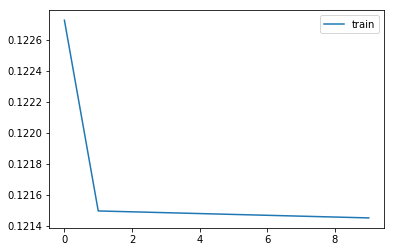

In [112]:
# plot history
plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Make Predictions and Plot ROC-AUC Metric

In [ ]:
# Make predictions with stacked LSTMs
trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(X_test, batch_size=batch_size)

In [36]:
# Make predictions with regular LSTM
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, testPredict)

In [38]:
auc = auc(fpr, tpr)

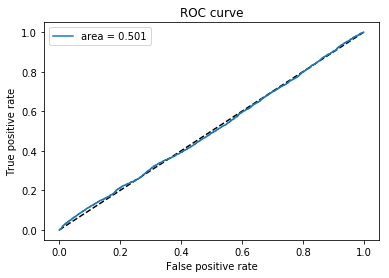

In [39]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, 
         label='area = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

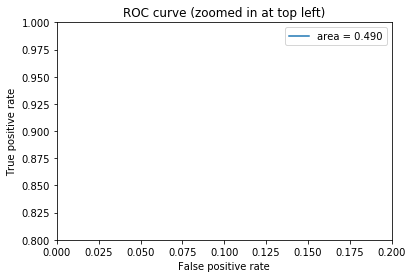

In [152]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, 
         label='area = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show() 

In [51]:
df_tst = pd.DataFrame(y_test)
df_tst[0].value_counts()

1.0    13178
0.0     3045
Name: 0, dtype: int64

# LSTM (Phony Data)

Adding a reference to the values attribute changes nothing.

In [163]:
y2 = np.stack(df_test.Attack.values)

In [164]:
y2[0]

array([[1.]])

In the next section, we'll use Numpy's random number generator to create phony data.

In [16]:
np.random.rand(1, 2).tolist()

[[0.45583479289738404, 0.21757927986735615]]

In [31]:
x = np.random.rand(150, 100, 10088).tolist()
pd.DataFrame(x).shape

(150, 100)

In [3]:
x = np.random.rand(150, 100, 10088).tolist()
df = pd.DataFrame({"sigccm" : x})
cell = df["sigccm"][0]

In [4]:
df.shape, type(cell), pd.DataFrame(cell).shape

((150, 1), list, (100, 10088))

In [5]:
np.round(np.random.rand(10), decimals=0)

array([0., 0., 1., 0., 1., 0., 1., 0., 1., 0.])

**Creating Phony Data**

In [8]:
x = np.random.rand(150, 100, 10088).tolist()
df = pd.DataFrame({"sigccm" : x})

In [9]:
bools = np.round(np.random.rand(150), decimals=0)
attack = pd.Series(bools)
df["Attack"] = attack
df.head()

,sigccm,Attack
0,"[[0.678836519498704, 0.6638220771352924, 0.394...",0.0
1,"[[0.9729769191557206, 0.34775875908483944, 0.1...",1.0
2,"[[0.4898145090325974, 0.8010816779466625, 0.62...",0.0
3,"[[0.14739207553348754, 0.09734288838161331, 0....",0.0
4,"[[0.5490501707745227, 0.3838102347864333, 0.64...",1.0


**Data Prep with Phony Data**

In [10]:
genbatchfiles(df, batchID = "phony", batch_size = 20)

In [11]:
params = {'batchID': "phony", 'batch_size': 20, 'dim': (100, 10088)}

Using generator class.

In [11]:
dg = DataGenerator(**params)

Using generator routine.

In [36]:
def data_generator(batchID, 
                   batch_size = 32, 
                   dim = (32,32,32)):

    print("In data_generator.")        
    
    DataDir = "data/"
    BatchDir = DataDir + batchID + "/"
    
    datafile_IDs = []
    labelfile_IDs = []

    path = BatchDir + "datafilenames_" + batchID + ".pkl"                                    
    fd = open(path, "rb")
    datafile_IDs = pkl.load(fd)
    fd.close()

    path = BatchDir + "labelfilenames_" + batchID + ".pkl"        
    fd = open(path, "rb")
    labelfile_IDs = pkl.load(fd)
    fd.close()       
    
    while True:
        for index in range(len(datafile_IDs)):

            'Generate one batch of data'

            datafn = datafile_IDs[index]        
            labelfn = labelfile_IDs[index] 

            # print("In data_generator loop:")        
            # print("index = %d, datafn = %s, labelfn = %s" % (
            #        index, datafn, labelfn))        

            # Initialize data arrays for this batch     
            X = np.empty((batch_size, *dim))
            y = np.empty((batch_size), dtype=int)         

            # Read data
            datafn = BatchDir + datafn
            X = np.load(datafn)

            # Read label
            labelfn = BatchDir + labelfn
            y = np.load(labelfn)

            yield X, y  

**LSTM with Phony Data**

In [37]:
time_series_length, input_dim, output_dim = 100, 10088, 1
time_series_length, input_dim, output_dim

(100, 10088, 1)

In [38]:
# Build the model
model = Sequential()

In [39]:
# I arbitrarily picked the output dimensions as 20
model.add(LSTM(20, 
               input_shape=(time_series_length, input_dim))) 

# The max output value is > 1 so relu is used as final activation.
model.add(Dense(output_dim, activation='relu'))

model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])
# model.compile(loss='mae', optimizer='adam') 

In [40]:
params = {'batchID': "short", 'batch_size': 20, 'dim': (100, 10088)}

In [41]:
dg = data_generator(**params)

In [42]:
model.fit_generator(generator = dg,
                    steps_per_epoch = 5,
                    epochs=10, 
                    verbose=1,
                    workers=1,
                    use_multiprocessing=False)

In data_generator.Epoch 1/10

5/5 [==============================] - 2s 303ms/step - loss: 1.0000 - acc: 0.0000e+00
Epoch 2/10
5/5 [==============================] - 1s 250ms/step - loss: 1.0000 - acc: 0.0000e+00
Epoch 3/10
5/5 [==============================] - 1s 262ms/step - loss: 1.0000 - acc: 0.0000e+00
Epoch 4/10
5/5 [==============================] - 1s 260ms/step - loss: 1.0000 - acc: 0.0000e+00
Epoch 5/10
5/5 [==============================] - 1s 253ms/step - loss: 1.0000 - acc: 0.0000e+00
Epoch 6/10
5/5 [==============================] - 1s 257ms/step - loss: 1.0000 - acc: 0.0000e+00
Epoch 7/10
5/5 [==============================] - 1s 269ms/step - loss: 1.0000 - acc: 0.0000e+00
Epoch 8/10
5/5 [==============================] - 1s 262ms/step - loss: 1.0000 - acc: 0.0000e+00
Epoch 9/10
5/5 [==============================] - 1s 256ms/step - loss: 1.0000 - acc: 0.0000e+00
Epoch 10/10
5/5 [==============================] - 1s 265ms/step - loss: 1.0000 - acc: 0.0000e+00


# LSTM (withtout Generator)

In [181]:
df_input = df_lstm_100_rows_2000_ccm_100

In [127]:
df_input.shape

(2000, 91)

In [128]:
sigccm = df_input["sigccm"]

Shape of a single element in the `sigccm` column should be:

    window size X flattened ccm size

In [129]:
max_sequence_length, input_length = pd.DataFrame(sigccm[0]).shape
max_sequence_length, input_length

(100, 10088)

In [130]:
# Head and tail do not have fully defined rolling windows
# Truncate them. 
df_input = df_input[10:-10]
df_input.shape

(1980, 91)

In [131]:
df_input.index = range(len(df_input))

In [15]:
# df_input.sigccm.tolist()
X_train_init = np.asarray(df_input.sigccm)

In [19]:
X_train_init[:3]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [16]:
(len(X_train_init[1]),
df_input.sigccm.apply(len).min(), 
df_input.sigccm.apply(len).max(),
X_train_init.shape, np.asarray(X_train_init[0]).shape)

(100, 100, 100, (1980,), (100, 10088))

In [17]:
# X_train = np.hstack(X_train_init).reshape(
X_train = np.column_stack(X_train_init).reshape(
                    len(df_input),
                    max_sequence_length,
                    input_length)

MemoryError: 

In [116]:
output_cols = ['Attack']

In [21]:
df_input['Attack'] = df_input[output_cols].apply(
                                     tuple, axis=1).apply(list)

In [22]:
y_train = np.hstack(np.asarray(df_input.Attack)).reshape(
                    len(df_input),len(output_cols))

In [23]:
len(y_train)

86223

In [24]:
X_test = X_train[70000:]
y_test = y_train[70000:]

In [25]:
X_train = X_train[:70000]
y_train = y_train[:70000]

In [26]:
# Get input dimensions

# Input length is the length for one input sequence 
# (i.e. the number of rows in a sample)
# Input dim is the number of dimensions in one input vector 
# (i.e. number of input columns)
input_length = X_train.shape[1]
input_dim = X_train.shape[2]

input_length, input_dim

(10, 488)

In [27]:
# Output dimension is just the shape of a single output vector
# In this case it's just 1, but it could be more
output_dim = len(y_train[0])
output_dim

1

**Build the LSTM Model**

In [231]:
# Build the model
model = Sequential()

In [ ]:
# Stacked LSTMs
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), 
               stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), 
               stateful=True))
model.add(Dense(output_dim))
model.compile(loss='mean_squared_error', optimizer='adam')

In [226]:
X_train.shape

(20, 100, 10088)

In [225]:
time_series_length, input_dim

(100, 10088)

In [232]:
# I arbitrarily picked the output dimensions as 20
model.add(LSTM(20, 
               input_shape=(time_series_length, input_dim))) 

# The max output value is > 1 so relu is used as final activation.
model.add(Dense(output_dim, activation='relu'))

model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])
# model.compile(loss='mae', optimizer='adam') 

In [ ]:
# Fit stacked LSTMs
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, 
              verbose=2, shuffle=False)
    model.reset_states()

In [233]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((20, 100, 10088), (20,), (20, 100, 10088), (20,))

In [215]:
keras.backend.backend()

'tensorflow'

In [234]:
# Fit regular lSTM
early_stop_callback = EarlyStopping(monitor = "val_loss",
                                    verbose = 2, mode = 'min', 
                                    patience = 3)

# history = model.fit(X_train, y_train, epochs=100, batch_size = 10, 
#                     validation_data = (X_test, y_test), verbose = 2, 
#                     callbacks=[early_stop_callback],
#                     shuffle = False)

# history = model.fit(X_train, y_train, epochs=10, batch_size = 10, 
#                     validation_data = (X_test, y_test), verbose = 2, 
#                     shuffle = False)

history = model.fit(X_train, y_train, epochs=10, batch_size = 10, 
                    verbose = 2, shuffle = False)

Epoch 1/10
 - 1s - loss: 1.0588 - acc: 0.0000e+00
Epoch 2/10
 - 0s - loss: 0.2395 - acc: 0.5500
Epoch 3/10
 - 0s - loss: 0.0710 - acc: 0.9500
Epoch 4/10
 - 0s - loss: 0.0608 - acc: 0.9500
Epoch 5/10
 - 0s - loss: 0.0391 - acc: 0.9500
Epoch 6/10
 - 1s - loss: 0.0337 - acc: 0.9500
Epoch 7/10
 - 0s - loss: 0.0302 - acc: 0.9500
Epoch 8/10
 - 0s - loss: 0.0274 - acc: 0.9500
Epoch 9/10
 - 0s - loss: 0.0249 - acc: 0.9500
Epoch 10/10
 - 0s - loss: 0.0228 - acc: 0.9500


In [235]:
print("Done.")

Done.


Plot the training and test loss.

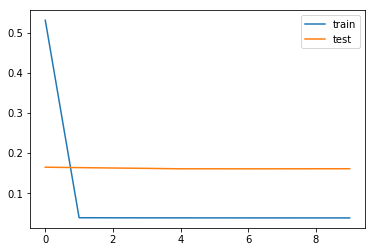

In [34]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

**Make Predictions and Plot ROC-AUC Metric**

In [ ]:
# Make predictions with stacked LSTMs
trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(X_test, batch_size=batch_size)

In [36]:
# Make predictions with regular LSTM
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, testPredict)

In [38]:
auc = auc(fpr, tpr)

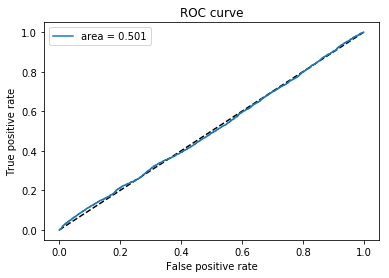

In [39]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, 
         label='area = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

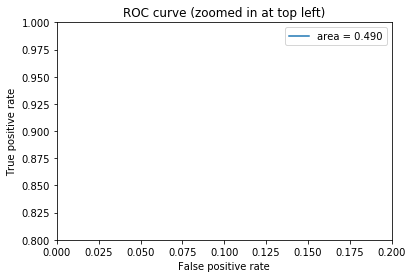

In [152]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, 
         label='area = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show() 

In [51]:
df_tst = pd.DataFrame(y_test)
df_tst[0].value_counts()

1.0    13178
0.0     3045
Name: 0, dtype: int64